## Generate the graph that will be use to create your playlist
This operation need to be executed just once

In [1]:
#import libraries
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
from scipy.spatial import cKDTree
from pygsp import graphs, filters
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
#setup plot
%matplotlib inline
import seaborn
plt.style.use('seaborn')#switch to seaborn style# TODO
seaborn.set_style(style='white')

---
### Parameters

In [3]:
# Hip-Hop
# Pop
# Folk
# Rock
# International
# Experimental
# Electronic
# Instrumental
genre_list = ['Rock','Folk','Hip-Hop']

node_pos = 100 # good position for heat diffusion example
tau = 70

---
#### Data Loading

In [4]:
#Load Data
tracks = pd.read_csv('data/tracks.csv', index_col=0, header=[0, 1]);
features_init= pd.read_csv('data/features.csv', index_col=0, header=[0, 1, 2])
genres=pd.read_csv('data/genres.csv', index_col=0, header=[0])

In [5]:
# setup the labels
label=pd.DataFrame({('label','genre','main'): tracks['track']['genre_top'],
                    ('label','genre','sub'): tracks['track']['genres']})

# Keep on the tracks from subset
label = label[tracks['set','subset'] == 'small']

# Keep only the genres we want
label = label[label['label']['genre']['main'].isin(genre_list)]

#add sub genres
genres_dict=genres['title'].to_dict()
genres_dict={str(key):genres_dict[key] for key in genres_dict}

#label['label']['genre']['sub']=label['label']['genre']['sub'].str.replace('[^0-9| ]','').str.split(' ').apply(lambda x:'|'.join([genres_dict[k] for k in x ]))

#normalize the features
dfmax=abs(features_init).max()
features=features_init.divide(dfmax)
np.save('data/dfmax',dfmax)
# create usable dataset
dataSet = features.merge(label, left_index=True, right_on='track_id')

In [6]:
#we calculate the distances of our dataset
distances = pdist(dataSet.drop(columns='label',level=0).values, metric='euclidean')

#We calculate the weights of our adjacency matrix
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
adjacency_full = squareform(weights)

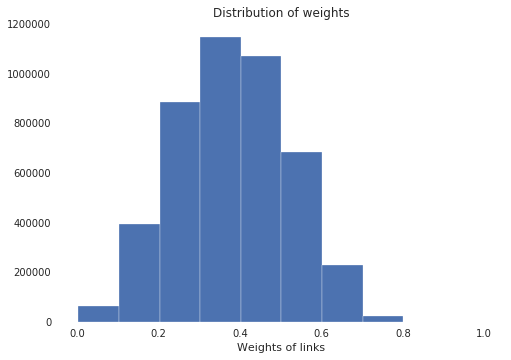

In [7]:
# Weights distribution plot
plt.hist(weights)
plt.title('Distribution of weights')
plt.xlabel('Weights of links')
plt.show()

In [8]:
#informatons over connectivity of main component 
adjacency=adjacency_full.copy() #we keep the original adjacency matrix
adjacency[adjacency < 0.65] = 0
graph=nx.from_numpy_matrix(adjacency)
print("#nodes= ",adjacency.shape[0])
print("#compo= ",nx.number_connected_components(graph))
list_comp=sorted(nx.connected_components(graph), key = len, reverse=True)
print("#nodes in giant component= ", len(list_comp[0]))
print("percentage of nodes in main component= ",len(list_comp[0])/adjacency.shape[0])

#nodes=  3000
#compo=  465
#nodes in giant component=  2512
percentage of nodes in main component=  0.8373333333333334


In [9]:
#set nodes id and genre
idx_dict={i : dataSet.index[i] for i in range(len(dataSet.index))}

# Save the dictionnary for heat diffusion
with open('data/idx_dict.pkl', 'wb') as handle:
    pickle.dump(idx_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# nx.set_node_attributes(graph, values=idx_dict, name="idx")

label_dict={i : dataSet.label.genre.main.values[i] for i in range(len(dataSet.label.genre.main.values))}
nx.set_node_attributes(graph, values=label_dict, name="genre")

graph=nx.relabel_nodes(graph,idx_dict)

In [10]:
#keep only the main component and corresponding label
conn_graph = list(nx.connected_component_subgraphs(graph))[0]
conn_label=label.iloc[list(list_comp[0])]
dataSetConn=dataSet.iloc[list(list_comp[0])]
#save dataset
dataSetConn.to_pickle('data/dataSet.csv')

In [11]:
#Possibility to export to visualize in Gephi
nx.write_gexf(conn_graph, "data/musicGraph.gexf")
np.save("data/connGraph.npy", nx.to_numpy_matrix(conn_graph))

In [12]:
#Use a numerical label for plotting usage
label_num=np.array(conn_label.label.genre.main)

for i,name in enumerate(conn_label.label.genre.main.unique()):
    label_num[label_num==name]=i
    print(name," ",i)    

Hip-Hop   0
Folk   1
Rock   2


In [13]:
#Calculate positions using a spring layout
coords = nx.spring_layout(conn_graph)
np.save("data/coords2D.npy",coords)

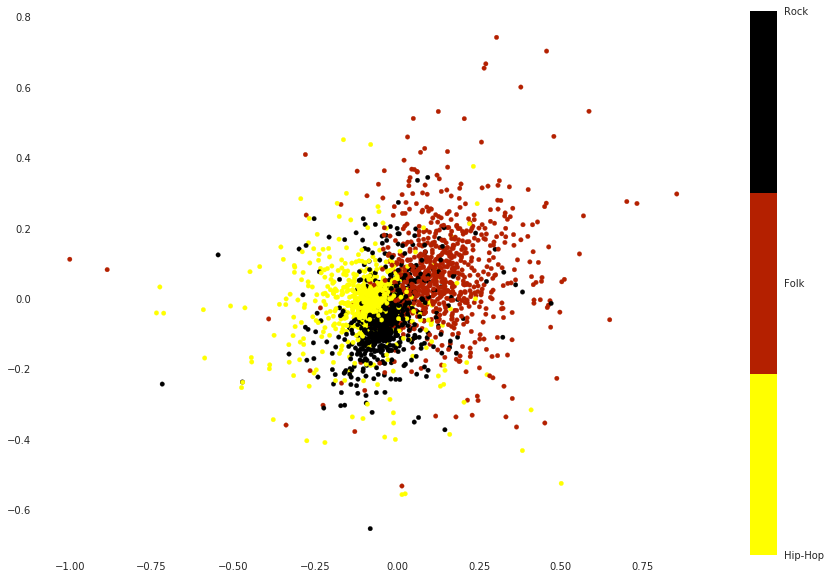

In [14]:
#Plot the resulting graph colored by genres
cmap = plt.cm.get_cmap('gnuplot_r', len(conn_label.label.genre.main.unique()))
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(conn_graph, coords,node_size=20, node_color=label_num, cmap=cmap)

# nx.draw_networkx_edges(conn_graph, coords, alpha=0.3)
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=np.min(label_num), vmax=np.max(label_num)), cmap=cmap)
sm._A = []
cbar = plt.colorbar(sm, ticks=range(len(conn_label.label.genre.main.unique())))
cbar.set_ticklabels(conn_label.label.genre.main.unique())
plt.show()

-----
## Heat diffusion

In [15]:
# Construct Graph
G = graphs.Graph(nx.to_numpy_matrix(conn_graph))
G.compute_fourier_basis()
G.set_coordinates()

In [16]:
# Dirac impulse on the given node
s = np.zeros(G.N)
s[node_pos]=1

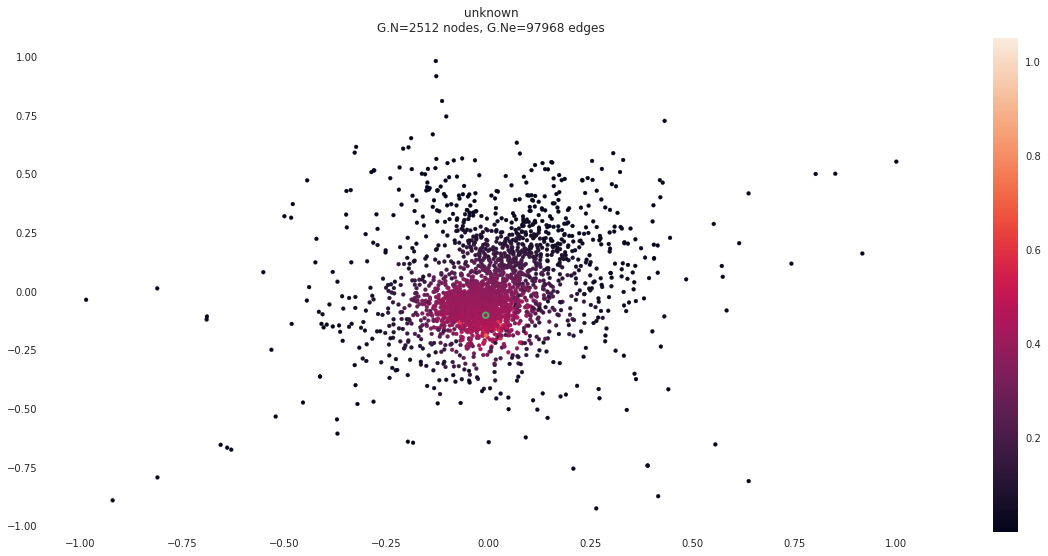

In [20]:
# Filtering and normalising
g = filters.Heat(G, tau, normalize=False)
s_out = g.filter(s, method='chebyshev')
s_out = s_out/max(s_out)

# Plotting
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(2, 1, 1)
G.plot_signal(s_out, colorbar=True, ax=ax,vertex_size=15, highlight=[node_pos])

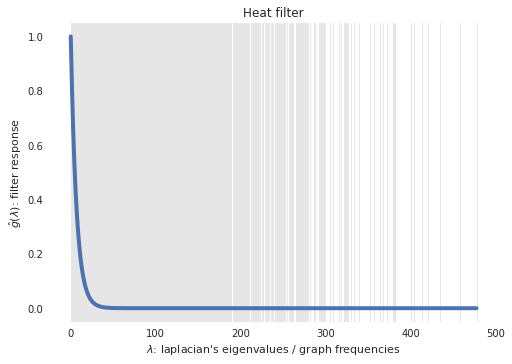

In [28]:
# Plot of the filter (kernel)
g.plot()
plt.title('Heat filter')
plt.show()